# Dataset

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from sklearn.model_selection import train_test_split

In [26]:
warnings.filterwarnings("ignore")

In [27]:
# import of emissions data for EU countries
df_europe = pd.read_csv('final_df_UE.csv')
df_europe.head()

,Country,Sector,Gas,year,cons
0,Austria,Agriculture,All GHG,2019,7.21
1,Austria,Agriculture,CH4,2019,4.64
2,Austria,Agriculture,N2O,2019,2.57
3,Austria,Building,All GHG,2019,8.41
4,Austria,Building,CO2,2019,7.73


In [28]:
# creation of timeseries CO2 emissions of France transportation sector
transport_co2 = df_europe[(df_europe['Country']== 'France') &
                          (df_europe['Sector']== 'Transportation')&
                          (df_europe['Gas']== 'CO2')]

transport_co2.index= pd.to_datetime(transport_co2['year'], format='%Y')

transport_co2.drop(['Country', 'Sector', 'Gas', 'year'], axis = 1, inplace = True)
transport_co2 = transport_co2.sort_index()

In [29]:
transport_co2

,cons
year,
1990-01-01,113.23
1991-01-01,116.85
1992-01-01,119.36
1993-01-01,120.48
1994-01-01,121.38
1995-01-01,122.32
1996-01-01,122.12
1997-01-01,124.64
1998-01-01,129.12


# Modelization

## Performance metrics

In [30]:
# creation of a function to calculate performance metrics

def calculate_scores(y_true,y_pred):
    print("MAE:", mean_absolute_error(y_true,y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))
    print("r2", r2_score(y_true,y_pred))


In [31]:
# creation of training and test datasets

train, test = train_test_split(transport_co2, test_size = 0.2, shuffle = False)

## Machine learning models

### Naive linear regression using years as feature

In [32]:
# creation of dataset for linear regression

X_train_lr = pd.DataFrame(train.index.year)
y_train_lr = train
X_test_lr = pd.DataFrame(test.index.year)
y_test_lr = test

In [33]:
#Linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_lr,y_train_lr)
y_pred_lr = lr.predict(X_test_lr)

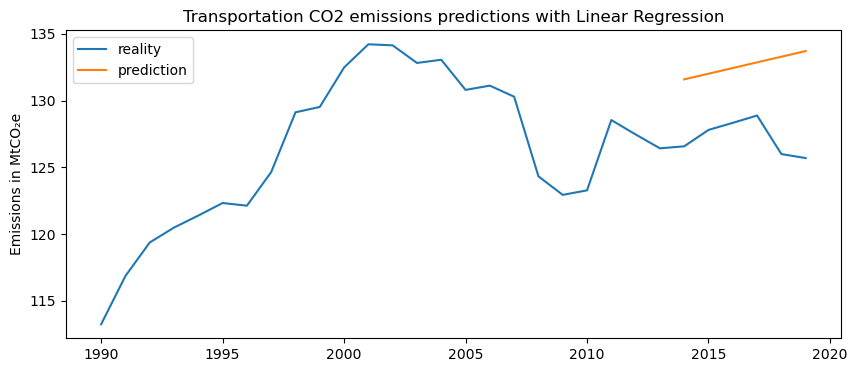

In [34]:

plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(X_test_lr, y_pred_lr, label ='prediction')
plt.title('Transportation CO2 emissions predictions with Linear Regression')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

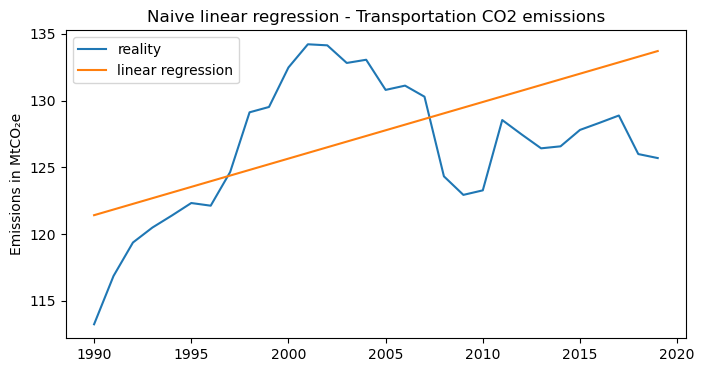

In [35]:
x = pd.DataFrame(transport_co2.index.year)
y = lr.predict(x)

plt.figure(figsize = (8,4))
plt.plot(x, transport_co2, label ='reality')
plt.plot(x, y, label ='linear regression')
plt.title('Naive linear regression - Transportation CO2 emissions')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

In [36]:
# performance metrics lr
calculate_scores(y_test_lr, y_pred_lr)

MAE: 5.441452898550646
RMSE: 5.6766199689128385
MAPE: 0.042888196622626974
r2 -21.482393268303817


In [37]:
#training on full dataset
lr.fit(np.array(transport_co2.index.year).reshape(-1,1), transport_co2 )


LinearRegression()

In [38]:
#Linear regression forecasts
X_forecast_lr = pd.DataFrame(range(2020, 2030))
y_forecast_lr = lr.predict(X_forecast_lr)


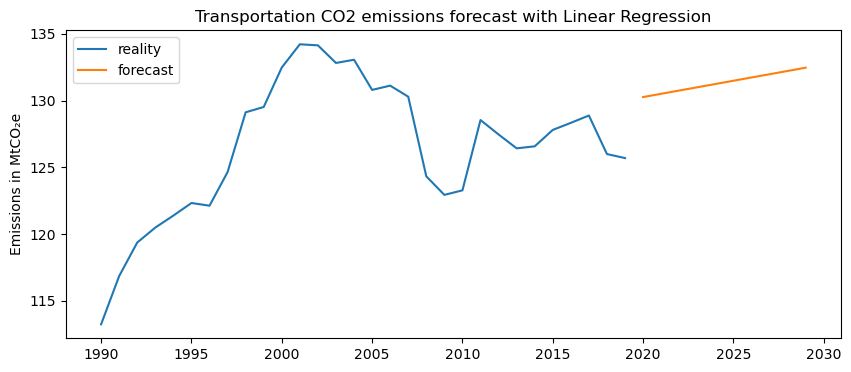

In [39]:
# Linear regression graph

plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(X_forecast_lr , y_forecast_lr, label = 'forecast')
plt.title('Transportation CO2 emissions forecast with Linear Regression')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

### Linear regression using the previous year as feature

In [40]:
def window_dataset(series, window):
    L = len(series)
    X = series.values
    df = pd.DataFrame(data = series.values)
    
    for i in range(window):
        y = []
        for i in range(L - 1):
            y.append(X[i+ 1])
        df = pd.concat([df,pd.DataFrame(y)], axis=1)
        L = L-1
        X = y  
    df.columns = ['X'+str(i) for i in range(window+1)]
    df.index = pd.to_datetime(range(1990 + window, 1990 + window + df.shape[0]), format='%Y')
    return df.iloc[:-window]

In [41]:
# new dataset with sliding window
new_df = window_dataset(transport_co2, window = 1)

In [42]:
X_train_w1, X_test_w1, y_train_w1, y_test_w1 = train_test_split(new_df[['X0']], new_df['X1'],test_size = 0.2, shuffle = False)


In [43]:
lr = LinearRegression()
lr.fit(X_train_w1,y_train_w1)
y_pred_lr = lr.predict(X_test_w1)

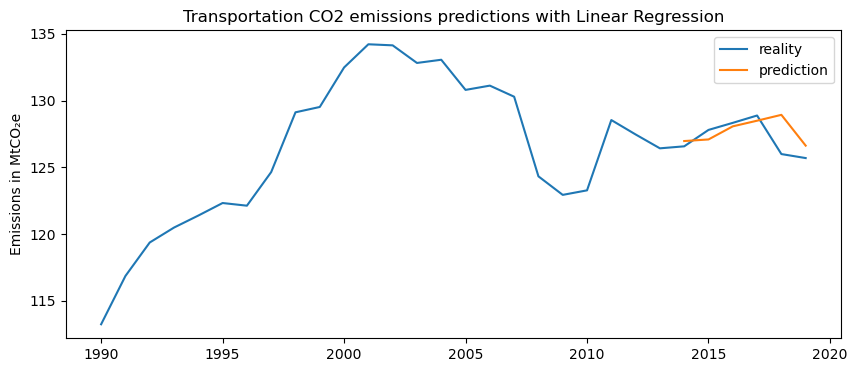

In [44]:
plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(X_test_w1.index.year, y_pred_lr, label ='prediction')
plt.title('Transportation CO2 emissions predictions with Linear Regression')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

In [45]:
calculate_scores(y_test_w1, y_pred_lr)

MAE: 0.9389548293440129
RMSE: 1.3167292282732073
MAPE: 0.007421915352382243
r2 -0.20963919667128184


In [46]:
#training on full dataset
lr = LinearRegression()
lr.fit(new_df[['X0']], new_df['X1'])

#forecasts

def forecasts_window1(model,first_year, n_years):
    x = transport_co2.tail(1)
    future = []

    for i in range(n_years):
        y = model.predict(x)
        future.append(y)
        x = pd.DataFrame(y)
    
    forecasts = pd.Series(data = future,
                          index = pd.to_datetime(range(first_year,first_year + n_years), format='%Y') )  
    
    return forecasts

forecasts_lr = forecasts_window1(lr,2020,10)

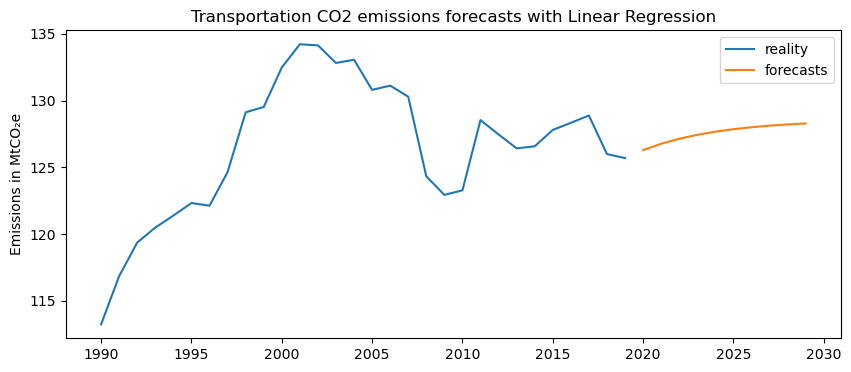

In [47]:
plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(forecasts_lr.index.year, forecasts_lr, label = 'forecasts')
plt.title('Transportation CO2 emissions forecasts with Linear Regression')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

### SVM using the previous year as feature

In [48]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


params = {'C': np.arange(1,11,10),
          'kernel': ['linear', 'rbf'],
          'epsilon': np.arange(0.1, 0.5, 0.1)}

model = SVR()
cv = GridSearchCV(model, param_grid = params )

cv.fit(X_train_w1, y_train_w1)

GridSearchCV(estimator=SVR(),
             param_grid={'C': array([1]),
                         'epsilon': array([0.1, 0.2, 0.3, 0.4]),
                         'kernel': ['linear', 'rbf']})

In [49]:
cv.best_params_

{'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}

In [50]:
y_pred_svm = cv.predict(X_test_w1)

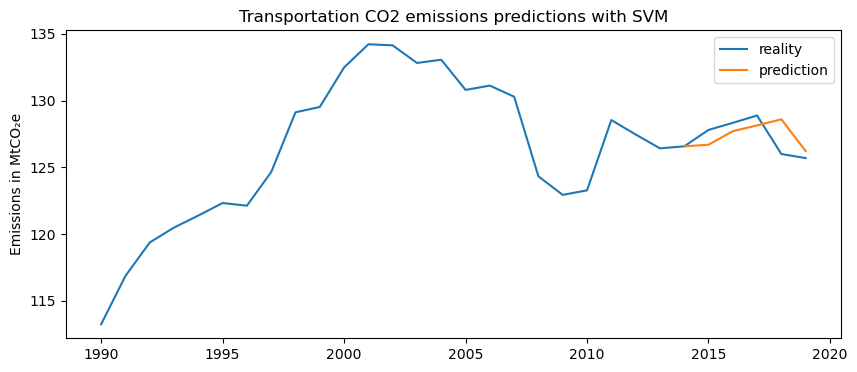

In [51]:
# svm graph

plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(X_test_w1.index.year, y_pred_svm, label ='prediction')
plt.title('Transportation CO2 emissions predictions with SVM')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

In [52]:
calculate_scores(y_test_w1,y_pred_svm)

MAE: 0.9338035436134362
RMSE: 1.2394719660224773
MAPE: 0.007355574197320024
r2 -0.07185568586870761


In [53]:
# training on full dataset, then forecasts
svm = SVR(C= 1, epsilon= 0.4, kernel = 'linear')
svm.fit(new_df[['X0']], new_df['X1'])

forecasts_svm = forecasts_window1(svm,2020,10)  


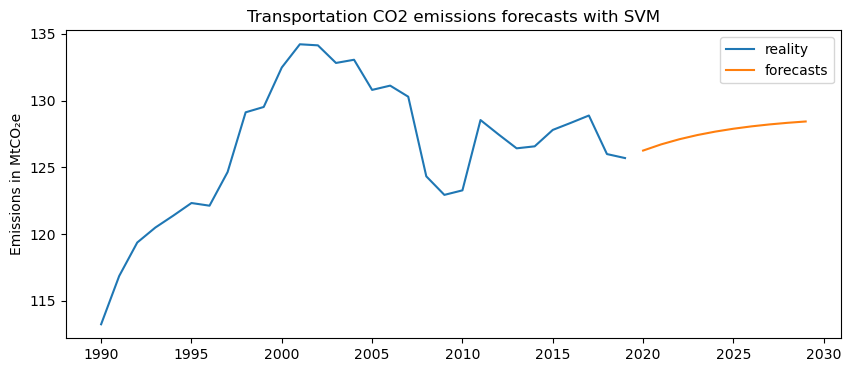

In [54]:
plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(forecasts_svm.index.year, forecasts_svm, label = 'forecasts')
plt.title('Transportation CO2 emissions forecasts with SVM')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

### SVM using the 5 previous years as features

In [55]:
# svm to predict emissions based on 5 previous years

new_df2 = window_dataset(transport_co2, window = 5)

y = new_df2['X5']
X = new_df2.drop('X5', axis = 1)

X_train_w5, X_test_w5, y_train_w5, y_test_w5 = train_test_split(X, y ,test_size = 0.2, shuffle = False)

cv2 = GridSearchCV(model, param_grid = params )

cv2.fit(X_train_w5, y_train_w5)

y_pred_svm = cv2.predict(X_test_w5)



In [56]:
cv2.best_params_

{'C': 1, 'epsilon': 0.4, 'kernel': 'linear'}

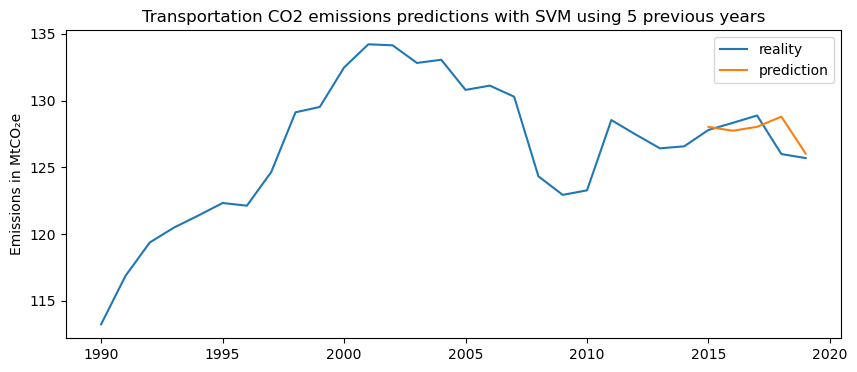

In [57]:
plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(X_test_w5.index.year, y_pred_svm, label ='prediction')
plt.title('Transportation CO2 emissions predictions with SVM using 5 previous years')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();

In [58]:
calculate_scores(y_test_w5,y_pred_svm)

MAE: 0.960542825098662
RMSE: 1.3486205964130207
MAPE: 0.0075728522526991
r2 -0.12155568941218431


In [59]:
# training on full dataset
svm = SVR(C = 1, epsilon = 0.4, kernel = 'linear')
svm.fit(X,y)

SVR(C=1, epsilon=0.4, kernel='linear')

In [60]:
#forecasts

feat = new_df2.iloc[-1:,1:6].values

future = []

for i in range(10):
    pred = svm.predict(feat.reshape(1, -1))
    future.append(pred)
    feat = np.delete(feat,[0])
    feat = np.append(feat,pred)

forecasts_svm5 = pd.Series(data = future, index = pd.to_datetime(range(2020,2030), format='%Y') )  

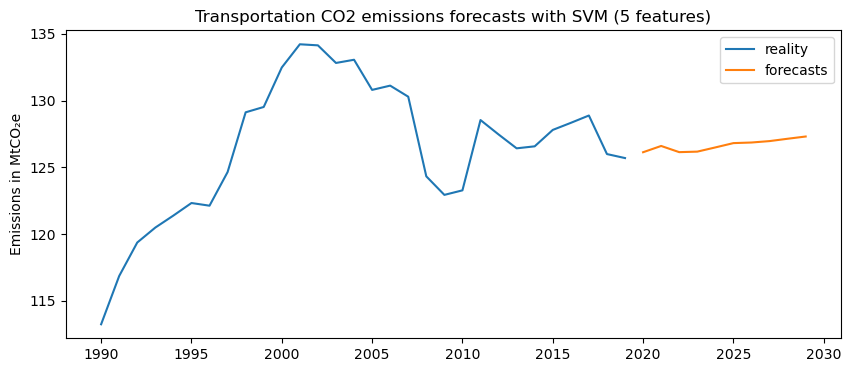

In [61]:
plt.figure(figsize = (10,4))
plt.plot(transport_co2.index.year, transport_co2, label ='reality')
plt.plot(forecasts_svm5.index.year, forecasts_svm5, label = 'forecasts')
plt.title('Transportation CO2 emissions forecasts with SVM (5 features)')
plt.ylabel("Emissions in MtCO₂e")
plt.legend();